In [44]:
import(Plots)

In [45]:
# Graph the graph
function graphplot(graph, chains)
    fig = Plots.plot(legend=false, aspect_ratio=:equal)
    #scatter!(coords[:, 1], coords[:, 2], linewidth=2)
    for chain in chains
        chain_xy = map(x -> graph[x].position, chain);
        x = getindex.(chain_xy, 1)
        y = getindex.(chain_xy, 2)
        Plots.plot!(x, y, linewidth=3)
        #println(coords[idx, 1])
        end;
    fig
    end;

In [12]:
## Force Layout 
const EPSILON = 1e-7

# Spring (+2 power)
function spring_energy(u, v)
    return (u^2 + v^2)
    end;
function spring_gradient(u, v)
    return (2*u, 2*v)
    end;

# Electric  (-2 power)
function repulsive_Coulomb_energy(u, v)
    return 1/(u^2 + v^2 + EPSILON)
    end;
function repulsive_Coulomb_gradient(u, v)
    d4 = (u^2 + v^2 + EPSILON)^2
    return (-2*u/d4, -2*v/d4)
    end;

# Inverse distance (-1 power)
function inverse_dist_energy(u, v)
    return 1/sqrt(u^2 + v^2 + EPSILON)
    end;

function inverse_dist_gradient(u, v)
    d3 = sqrt(u^2 + v^2 + EPSILON)^3
    return (-u/d3, -4*v/d3)
    end;

# The (attraction,repulsion)-model of ForceAtlas (1,-1)
# has an intermediate position between Noack’s LinLog (0,-1)
# and the algorithm of Fruchterman and Rheingold (2,-1),
# https://journals.plos.org/plosone/article/file?id=10.1371/journal.pone.0098679&type=printable

attractive_energy = spring_energy
attractive_gradient = spring_gradient
repulsive_energy = repulsive_Coulomb_energy
repulsive_gradient = repulsive_Coulomb_gradient

repulsive_Coulomb_gradient (generic function with 1 method)

In [13]:
using(BenchmarkTools)

In [14]:
mutable struct Node
    neighbors
    position #::Union{Nothing, Tuple{Float64, Float64}}
    velocity
    force
    energy
    previous_position
    previous_velocity
    previous_force
    previous_energy
    end;

Node() = Node([], nothing, nothing, nothing, nothing,
                  nothing, nothing, nothing, nothing)

Node

In [40]:
function compute_force!(graph, node_name)
    node = graph[node_name]
    node.force = (.0, .0)
    # Pairs and triplet
    for (left, right) in node.neighbors
        if ~isnothing(left) # and coords is not nothing (?) for partial graph
            u_left = node.position .- graph[left].position
            node.force = node.force .- attractive_gradient(u_left...)
            end;
        if ~isnothing(right)
            u_right = node.position .- graph[right].position
            node.force = node.force .- attractive_gradient(u_right...)
            end;
        if ~isnothing(left) && ~isnothing(right)
            # moment 
            end;
        end;

    # All
    for (name, other_node) in pairs(graph)
        if name == node_name
            continue
        else
            u = node.position .- other_node.position
            node.force = node.force .- repulsive_Coulomb_gradient(u...)
            end;
        end;
    end;

In [41]:
function compute_all_force!(graph)
    for node_name in keys(graph)
        compute_force!(graph, node_name)
        end;
    end;

In [92]:
# init graph data structure
function create_graph(chains)
    graph = Dict()
    for chain in chains
        node = get!(graph, chain[1], Node())
        push!(node.neighbors, (nothing, chain[2]))

        for k in 2:length(chain)-1
            node = get!(graph, chain[k], Node())
            push!(node.neighbors, (chain[k-1], chain[k+1]))
            end;

        node = get!(graph, chain[end], Node())
        push!(node.neighbors, (chain[end-1], nothing))
        end;

    # init coordinates (on a circle)
    N = length(graph)
    radius = N/(2*pi)
    delta_theta = 2*pi/N
    for (k, node) in enumerate(values(graph))
        theta = k*delta_theta
        node.position = (radius*cos(theta), radius*sin(theta))
        node.previous_position = node.position
        node.velocity = (0.0, 0.0)
        node.previous_velocity = (0.0, 0.0)
        end;

    compute_all_force!(graph)
    
    # init previous forces
    for node in values(graph)
        node.previous_force = node.force
        end;
    
    return graph
    end;

In [134]:
# Velocity Verlet
# http://students.iitk.ac.in/projects/wiki/lib/exe/fetch.php?media=2014as:verlet.pdf
function velocity_verlet!(graph, dt)
    dt2_2 = dt^2 / 2
    
    # positions
    for node in values(graph)
        node.position = node.position .+ (dt2_2).*node.force
        node.previous_force = node.force
        end;
    
    # forces
    compute_all_force!(graph)

    # velocities
    for node in values(graph)
        node.velocity = node.velocity .+ (node.force .+ node.previous_force).*(0.5dt)    
        end;
    
    end;

In [129]:
dot(a, b) = sum(a .* b)
norm(a) = sqrt(dot(a, a))
unit_vector(a) = a./norm(a)

unit_vector (generic function with 1 method)

In [147]:
# https://github.com/mauro3/Parameters.jl
# import Pkg; Pkg.add("Parameters")
using Parameters

In [277]:
@with_kw mutable struct Fire
    N_min = 5
    f_inc = 1.1
    f_dec = 0.5
    alpha_start = 0.1
    f_alpha = 0.99
    dt_max = .5
    # variable
    dt = dt_max / 5.0
    N = 0
    alpha = alpha_start
end

Fire

In [306]:
# Fire minimization
# Bitzek, Erik, et al. "Structural relaxation made simple."
# Physical review letters 97.17 (2006): 170201.

function step!(graph, fire)
    
    # loop
    velocity_verlet!(graph, fire.dt)

    P = sum( dot(node.force, node.velocity) for node in values(graph) )

    for node in values(graph)
        hat_F = unit_vector(node.force)
        v = node.velocity
        node.velocity = (1 - fire.alpha).*v .+ (fire.alpha * norm(v)).*hat_F  
        end;

    if P > 0 && fire.N > fire.N_min
        fire.dt = min(fire.f_inc*fire.dt, fire.dt_max)
        fire.alpha = fire.alpha * fire.f_alpha
        fire.N = 0
    elseif P > 0
        fire.N += 1
        end;
    
    if P <= 0
        fire.dt = fire.f_dec * fire.dt
        fire.alpha = fire.alpha_start
        foreach(node -> node.velocity = (0.0, 0.0), values(graph))
        fire.N = 0
        end;

    end;

In [317]:
# test graph
chains = [["A", "B", "C", "D", "E"],
          ["R", "E", "T", "ER", "erz", "ZE"],
          ["C", "re", "eze"]]

graph = create_graph(chains)

Dict{Any,Any} with 12 entries:
  "T"   => Node(Any[("E", "ER")], (1.65399, 0.95493), (0.0, 0.0), (-6.53263, -4…
  "C"   => Node(Any[("B", "D"), (nothing, "re")], (0.95493, 1.65399), (0.0, 0.0…
  "erz" => Node(Any[("ER", "ZE")], (1.16945e-16, 1.90986), (0.0, 0.0), (2.16493…
  "B"   => Node(Any[("A", "C")], (-0.95493, 1.65399), (0.0, 0.0), (2.96441, -5.…
  "ER"  => Node(Any[("T", "erz")], (-1.65399, 0.95493), (0.0, 0.0), (8.44249, 2…
  "re"  => Node(Any[("C", "eze")], (-1.90986, 2.3389e-16), (0.0, 0.0), (4.53071…
  "eze" => Node(Any[("re", nothing)], (-1.65399, -0.95493), (0.0, 0.0), (-1.993…
  "A"   => Node(Any[(nothing, "B")], (-0.95493, -1.65399), (0.0, 0.0), (-0.8553…
  "D"   => Node(Any[("C", "E")], (-3.50835e-16, -1.90986), (0.0, 0.0), (3.81972…
  "E"   => Node(Any[("D", nothing), ("R", "T")], (0.95493, -1.65399), (0.0, 0.0…
  "ZE"  => Node(Any[("erz", nothing)], (1.65399, -0.95493), (0.0, 0.0), (-1.826…
  "R"   => Node(Any[(nothing, "E")], (1.90986, -4.67781e-16), (0.0, 0.0), (-0.

In [318]:
# init
fire = Fire(dt_max=.3)

step!(graph, fire)
println("dt ", fire.dt)
println("alpha ", fire.alpha)

dt 0.06
alpha 0.1


In [319]:
step!(graph, fire)

In [320]:
for k in 1:500
    step!(graph, fire)
end

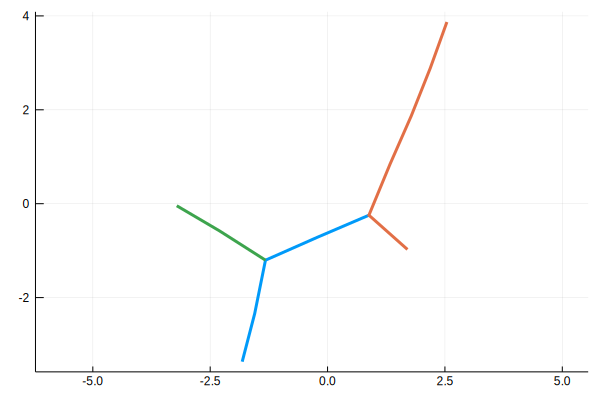

In [321]:
graphplot(graph, chains)

In [322]:
fire

Fire
  N_min: Int64 5
  f_inc: Float64 1.1
  f_dec: Float64 0.5
  alpha_start: Float64 0.1
  f_alpha: Float64 0.99
  dt_max: Float64 0.3
  dt: Float64 0.3
  N: Int64 5
  alpha: Float64 0.0489890273004205
